# Exercise 1: Google Stock Price

You are tasked to make use of historical stock data from Google to perform forecasting.
For single-step forecasting, you need to use 30 days worth of data to predict the 'Open' stock price for the next day.
For multi-step forecasting, you need to use the past 30 days worth of data to predict the next 30 days of 'Open' stock price.

1. Perform data inspection, data cleaning, feature engineering (if necessary), data splitting and data normalization.
2. Perform the necessary data windowing, please refer to the above introductory instruction to decide the windowing configuration.
3. To create the data window and the TensorFlow dataset, you may import the WindowGenerator class that is used in the tutorial.
4. Construct a LSTM model and train the model to perform the prediction.
5. Plot the result of the prediction along with the label

### 1. Import packages and setup

In [1]:
import os
import datetime
 
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from wg_class import WindowGenerator

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

### 2. Load the data file

In [2]:
# Load the data
CSV_PATH = os.path.join(os.getcwd(), 'Google_Stock_Price.csv')

In [3]:
os.getcwd()

'c:\\Users\\Hafiz Jasmi\\Desktop\\ai04_hands_ on'

In [4]:
df = pd.read_csv(CSV_PATH) 

### 3. Data inspection

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1278.0,537.994906,154.508365,279.12,406.0375,538.395,668.8625,837.81
High,1278.0,542.168897,155.582501,281.21,408.2300,542.330,677.7050,841.95
Low,1278.0,533.278803,153.174011,277.22,403.3350,534.355,662.1900,827.01


In [7]:
# Check for missing values in the data
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 60.0+ KB


### 4. Data cleaning

In [9]:
#Extract out the date
date_time = pd.to_datetime(df.pop('Date'), format='%m/%d/%Y')

<Figure size 800x600 with 0 Axes>

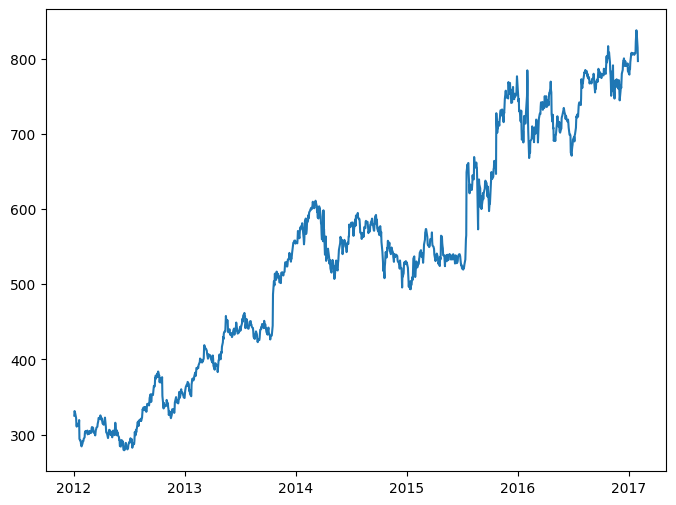

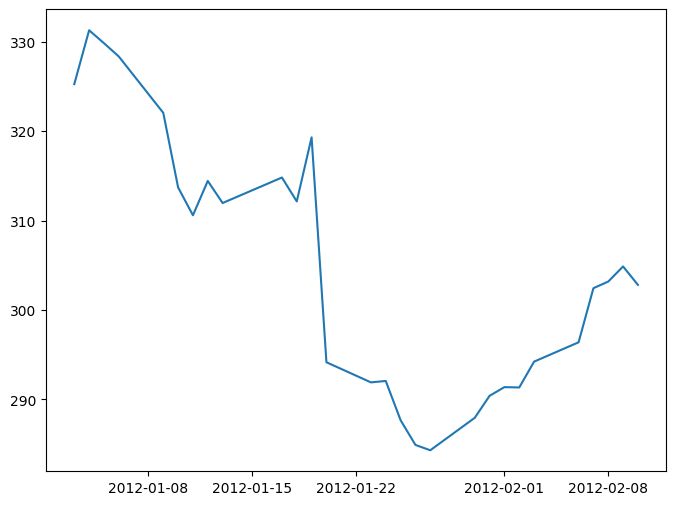

<Figure size 800x600 with 0 Axes>

In [10]:
#plot some graphs to see the trend of the stock price
#i.Overall graph
plt.plot(date_time, df['Open'].values)
plt.figure()
#ii.Weekly trend graph
plt.plot(date_time[0:28], (df['Open']).values[0:28])
plt.figure()

- Both 'Close' & 'Volume' contain comma in their values. We need to remove them first then only can convert the string into float.

In [11]:
# Convert 'Close' column to numerical values
df['Close'] = df['Close'].str.replace(',', '').astype('float64')

In [12]:
# Convert 'Volume' to numeric and remove commas
df['Volume'] = df['Volume'].str.replace(',', '').astype('float64')

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1278.0,5.379949e+02,1.545084e+02,279.12,4.060375e+02,538.395,6.688625e+02,837.81
High,1278.0,5.421689e+02,1.555825e+02,281.21,4.082300e+02,542.330,6.777050e+02,841.95
Low,1278.0,5.332788e+02,1.531740e+02,277.22,4.033350e+02,534.355,6.621900e+02,827.01
Close,1278.0,7.141600e+02,1.638924e+02,491.20,5.784125e+02,698.150,7.855725e+02,1216.83
Volume,1278.0,3.134661e+06,2.265015e+06,7900.00,1.608700e+06,2528700.000,4.106200e+06,24977900.00


### 5. Data splitting

In [14]:
#Dictionary to hold the column names and their index as key-value pair
#70:20:10 split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

### 6. Data normalization

In [15]:
#Extract out the column names
column_names = df.columns.values

In [16]:
mms = MinMaxScaler()
train_df_normalized = mms.fit_transform(train_df)
val_df_normalized = mms.transform(val_df)
test_df_normalized = mms.transform(test_df)

In [17]:
train_df_normalized[0:5]

array([[0.12071176, 0.12988451, 0.12507203, 0.23757287, 0.29525831],
       [0.13646474, 0.13250132, 0.13583739, 0.24151427, 0.22993592],
       [0.13269659, 0.12465088, 0.13010111, 0.22878051, 0.26361233],
       [0.12879759, 0.11966887, 0.12169312, 0.21641884, 0.21617942],
       [0.11231192, 0.10336411, 0.08444654, 0.1785483 , 0.46779736]])

In [18]:
#scaler returns ndarray, convert it back to DataFrame
train_df = pd.DataFrame(train_df_normalized, columns=column_names)
val_df = pd.DataFrame(val_df_normalized, columns=column_names)
test_df = pd.DataFrame(test_df_normalized, columns=column_names)

In [19]:
train_df.head()

,Open,High,Low,Close,Volume
0,0.120712,0.129885,0.125072,0.237573,0.295258
1,0.136465,0.132501,0.135837,0.241514,0.229936
2,0.132697,0.124651,0.130101,0.228781,0.263612
3,0.128798,0.119669,0.121693,0.216419,0.216179
4,0.112312,0.103364,0.084447,0.178548,0.467797


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1278.0,5.379949e+02,1.545084e+02,279.12,4.060375e+02,538.395,6.688625e+02,837.81
High,1278.0,5.421689e+02,1.555825e+02,281.21,4.082300e+02,542.330,6.777050e+02,841.95
Low,1278.0,5.332788e+02,1.531740e+02,277.22,4.033350e+02,534.355,6.621900e+02,827.01
Close,1278.0,7.141600e+02,1.638924e+02,491.20,5.784125e+02,698.150,7.855725e+02,1216.83
Volume,1278.0,3.134661e+06,2.265015e+06,7900.00,1.608700e+06,2528700.000,4.106200e+06,24977900.00


In [21]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,894.0,0.463532,0.269662,0.0,0.196729,0.468167,0.688192,1.0
High,894.0,0.449176,0.260831,0.0,0.191134,0.447941,0.671288,1.0
Low,894.0,0.458687,0.267365,0.0,0.194307,0.462780,0.684877,1.0
Close,894.0,0.299058,0.265197,0.0,0.090697,0.187072,0.488703,1.0
Volume,894.0,0.146181,0.098435,0.0,0.076410,0.134734,0.181820,1.0


### 7. Data windowing

In [22]:
single_window = WindowGenerator(input_width=30,
label_width=30, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Open'])

multi_window = WindowGenerator(input_width=30,
label_width=30, shift=30, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Open'])

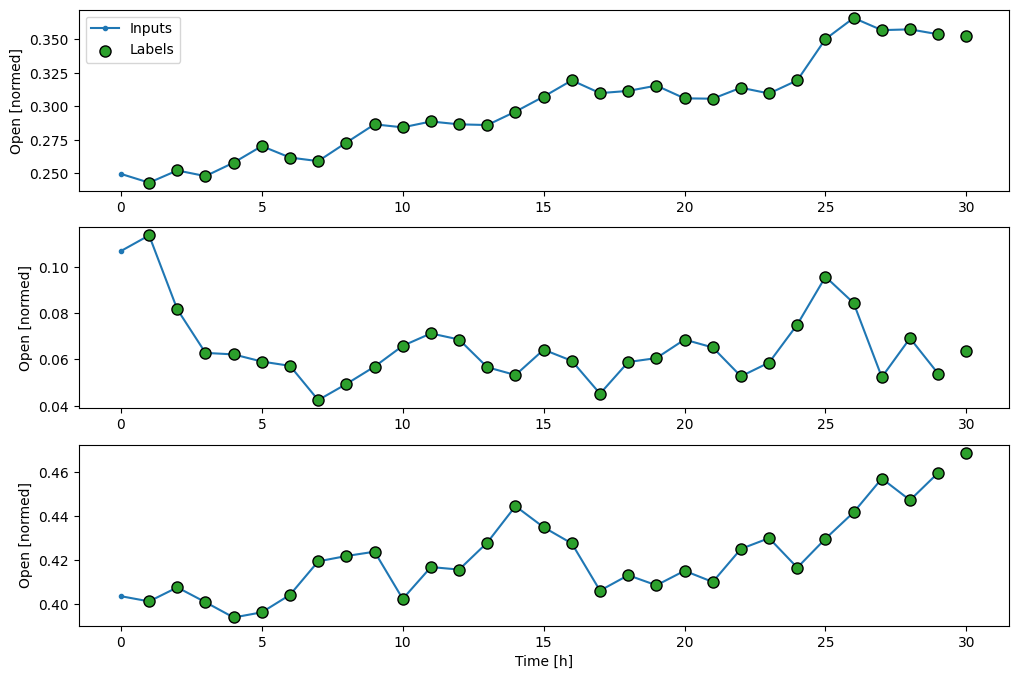

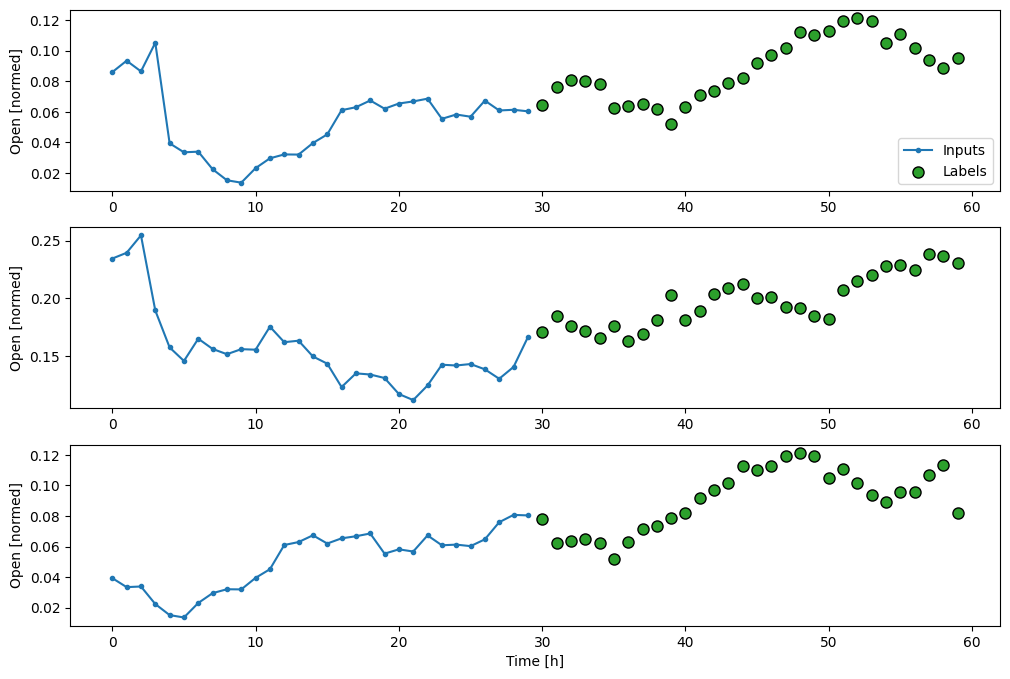

In [23]:
#plot example to check the window indexes
single_window.plot(plot_col='Open')
multi_window.plot(plot_col='Open')

### 8. Model development

#### Single step model

In [24]:
single_model = keras.models.Sequential()
single_model.add(keras.layers.LSTM(32,return_sequences=True))
single_model.add(keras.layers.Dense(1))

In [25]:
#compile the model
single_model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [26]:
#Model training
early_stopping = keras.callbacks.EarlyStopping(patience=3)

history_single = single_model.fit(single_window.train,
                                   validation_data=single_window.val, 
                                   epochs=20, callbacks=[early_stopping])

Epoch 1/20
27/27 [==============================] - 4s 31ms/step - loss: 0.0908 - mae: 0.2274 - val_loss: 0.1224 - val_mae: 0.2508
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0229 - mae: 0.1028 - val_loss: 0.0937 - val_mae: 0.2100
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0153 - mae: 0.0732 - val_loss: 0.0687 - val_mae: 0.1591
Epoch 4/20
27/27 [==============================] - 0s 10ms/step - loss: 0.0112 - mae: 0.0543 - val_loss: 0.0520 - val_mae: 0.1221
Epoch 5/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0091 - mae: 0.0481 - val_loss: 0.0426 - val_mae: 0.1049
Epoch 6/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0451 - val_loss: 0.0370 - val_mae: 0.0964
Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0068 - mae: 0.0417 - val_loss: 0.0327 - val_mae: 0.0903
Epoch 8/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.

In [27]:
#check the performance of the model
single_model.evaluate(single_window.test)

4/4 [==============================] - 0s 5ms/step - loss: 0.0127 - mae: 0.0606


[0.01265184860676527, 0.06059670448303223]

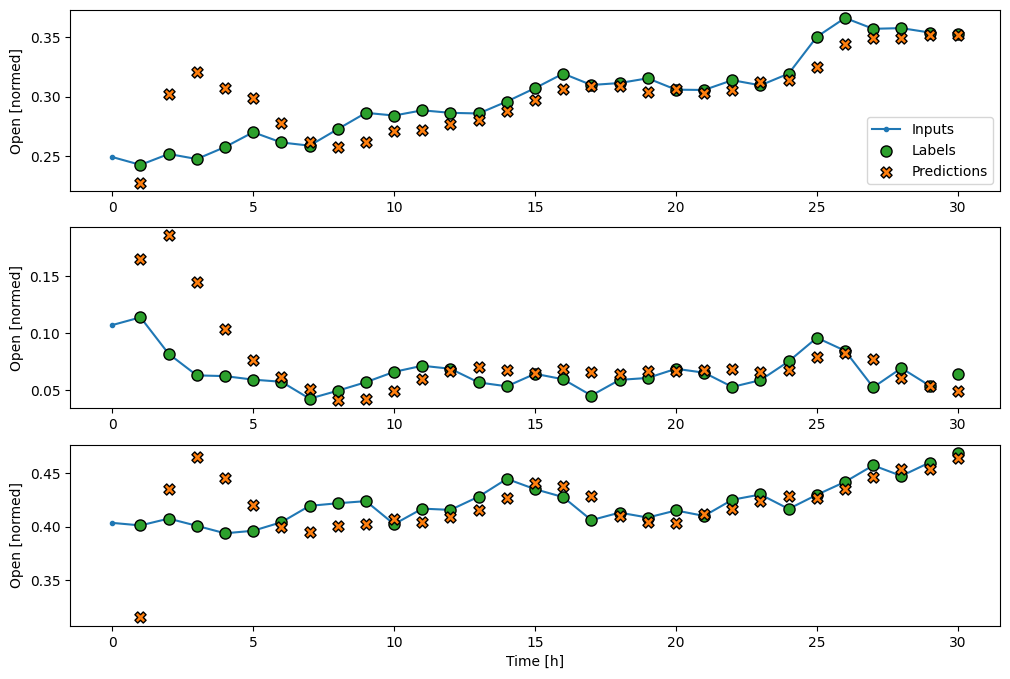

In [28]:
single_window.plot(single_model, plot_col='Open')

#### Multi-step model

In [29]:
multi_model = keras.models.Sequential()
multi_model.add(keras.layers.LSTM(32, return_sequences=True))
multi_model.add(keras.layers.Dropout(0.3))
multi_model.add(keras.layers.LSTM(32, return_sequences=False))
multi_model.add(keras.layers.Dropout(0.3))
multi_model.add(keras.layers.Dense(30*1))
multi_model.add(keras.layers.Reshape([30,1]))


In [30]:
#compile the model
multi_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [31]:
history_multi = multi_model.fit(multi_window.train, 
                                validation_data=multi_window.val, epochs=20, callbacks=[early_stopping])

Epoch 1/20
27/27 [==============================] - 5s 47ms/step - loss: 0.1739 - mae: 0.3288 - val_loss: 0.3917 - val_mae: 0.5800
Epoch 2/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0569 - mae: 0.1731 - val_loss: 0.1624 - val_mae: 0.3779
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0361 - mae: 0.1387 - val_loss: 0.1284 - val_mae: 0.3414
Epoch 4/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0288 - mae: 0.1251 - val_loss: 0.1105 - val_mae: 0.3179
Epoch 5/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0252 - mae: 0.1172 - val_loss: 0.0971 - val_mae: 0.2976
Epoch 6/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0221 - mae: 0.1101 - val_loss: 0.0973 - val_mae: 0.2995
Epoch 7/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0201 - mae: 0.1049 - val_loss: 0.1017 - val_mae: 0.3073
Epoch 8/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0185 - m

In [32]:
#evaluate the model with test data
multi_model.evaluate(multi_window.test)

3/3 [==============================] - 0s 9ms/step - loss: 0.1662 - mae: 0.4042


[0.16621066629886627, 0.40419650077819824]

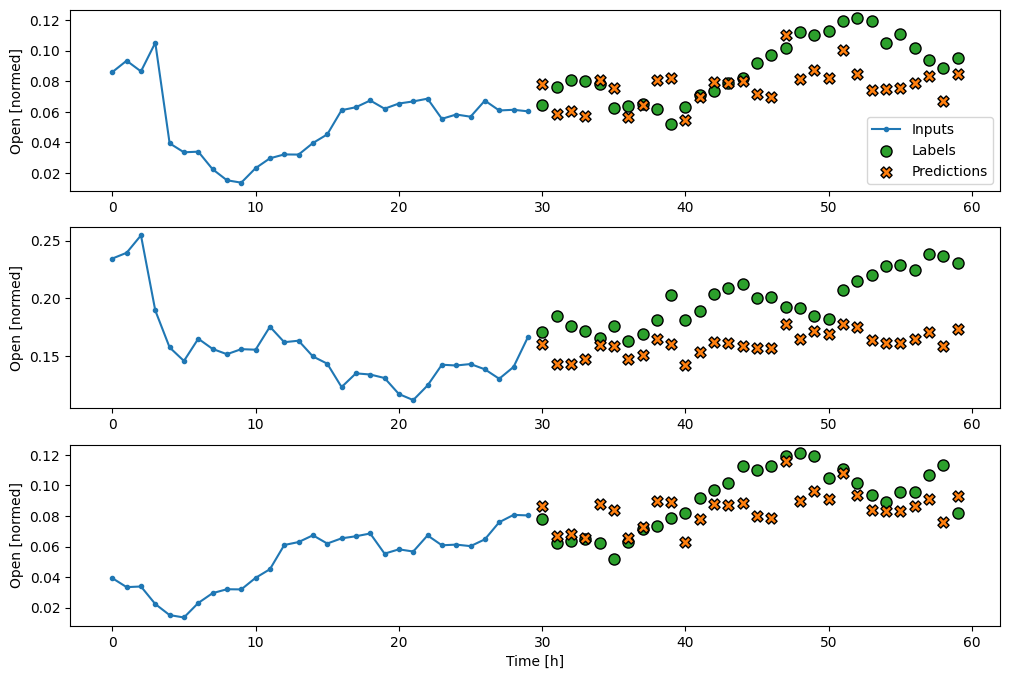

In [33]:
#plot the result
multi_window.plot(multi_model, plot_col='Open')

In [34]:
#use the test data to make predictions
features, labels = next(iter(multi_window.test))
predictions = multi_model.predict(multi_window.test)

3/3 [==============================] - 1s 21ms/step


In [35]:
predictions.shape

(69, 30, 1)

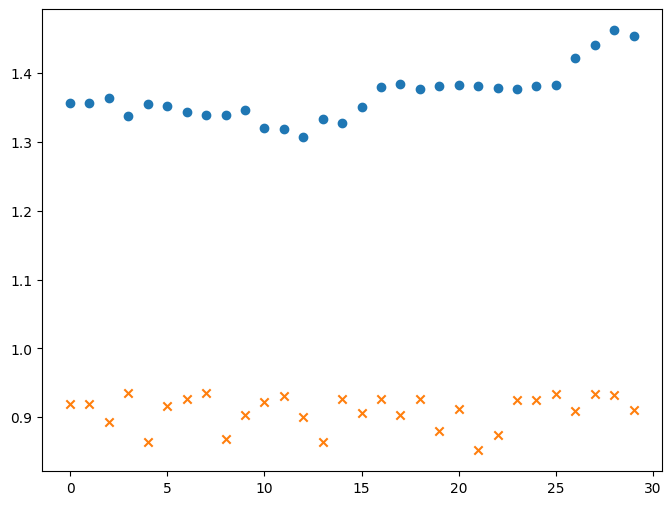

In [36]:
plt.figure()
plt.scatter(np.arange(30),labels[0, :, 0])
plt.scatter(np.arange(30),predictions[0, :, 0], marker='x')